In [7]:
import pandas as pd
import numpy as np
from google.colab import files
import io
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
print("Upload your CSV (consumer usage CSV)")
uploaded = files.upload()
fname = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded:", fname, "shape:", df.shape)
df.head()

Upload your CSV (consumer usage CSV)


Saving smart_meter_data.csv to smart_meter_data (2).csv
Loaded: smart_meter_data (2).csv shape: (30, 4)


,consumer_id,avg_hourly_usage_kwh,max_hourly_usage_kwh,night_usage_ratio
0,1,0.849671,1.319488,0.352083
1,2,0.786174,2.055683,0.381434
2,3,0.864769,1.495951,0.289367
3,4,0.952303,1.182687,0.280379
4,5,0.776585,1.746763,0.481253


In [9]:
required = ['consumer_id','avg_hourly_usage_kwh','max_hourly_usage_kwh','night_usage_ratio']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError("Missing columns: " + ", ".join(missing))

In [10]:
X = df[['avg_hourly_usage_kwh','max_hourly_usage_kwh','night_usage_ratio']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
iso = IsolationForest(contamination=0.1, random_state=42)
iso_labels = iso.fit_predict(X_scaled)
df['iso_anom'] = np.where(iso_labels == -1, 1, 0)
df['iso_score'] = iso.decision_function(X_scaled)

In [14]:
db = DBSCAN(eps=0.6, min_samples=3)
db_labels = db.fit_predict(X_scaled)
df['db_outlier'] = np.where(db_labels == -1, 1, 0)
df['db_label'] = db_labels

In [15]:
print("\nIsolation Forest anomalies (consumer_id, iso_score):")
print(df.loc[df['iso_anom']==1, ['consumer_id','iso_score']].sort_values('iso_score'))



Isolation Forest anomalies (consumer_id, iso_score):
    consumer_id  iso_score
26           27  -0.042744
27           28  -0.011387
25           26  -0.010641


In [16]:
print("\nDBSCAN outliers (consumer_id):")
print(df.loc[df['db_outlier']==1, ['consumer_id','db_label']])



DBSCAN outliers (consumer_id):
Empty DataFrame
Columns: [consumer_id, db_label]
Index: []


In [17]:
print("\nSummary counts:")
print("Total consumers:", len(df))
print("Isolation Forest flagged:", int(df['iso_anom'].sum()))
print("DBSCAN flagged:", int(df['db_outlier'].sum()))


Summary counts:
Total consumers: 30
Isolation Forest flagged: 3
DBSCAN flagged: 0


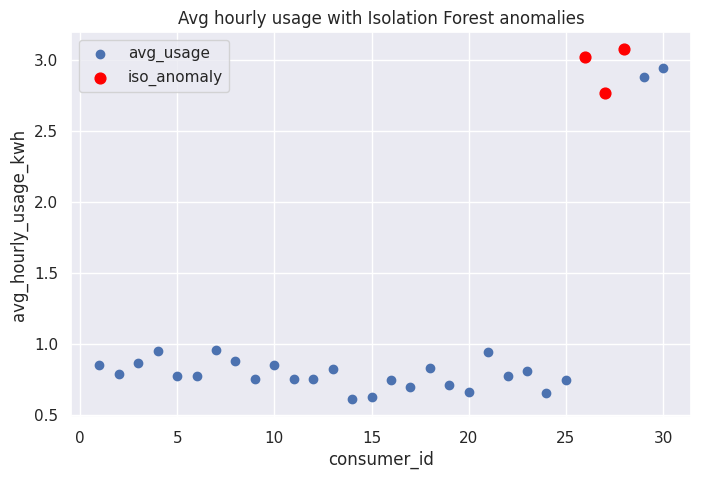

In [18]:
sns.set()
plt.figure(figsize=(8,5))
plt.scatter(df['consumer_id'], df['avg_hourly_usage_kwh'], label='avg_usage')
plt.scatter(df.loc[df['iso_anom']==1, 'consumer_id'], df.loc[df['iso_anom']==1, 'avg_hourly_usage_kwh'],
            color='red', label='iso_anomaly', s=60)
plt.xlabel('consumer_id')
plt.ylabel('avg_hourly_usage_kwh')
plt.title('Avg hourly usage with Isolation Forest anomalies')
plt.legend()
plt.show()

In [19]:
flagged_both = df[(df['iso_anom']==1) | (df['db_outlier']==1)].copy()
if not flagged_both.empty:
    print("\nFlagged consumers (either method):")
    display_cols = ['consumer_id','avg_hourly_usage_kwh','max_hourly_usage_kwh','night_usage_ratio','iso_anom','db_outlier','iso_score','db_label']
    print(flagged_both[display_cols].sort_values(['iso_anom','db_outlier','iso_score'], ascending=[False,False,True]).to_string(index=False))
else:
    print("\nNo consumers flagged by either method.")


Flagged consumers (either method):
 consumer_id  avg_hourly_usage_kwh  max_hourly_usage_kwh  night_usage_ratio  iso_anom  db_outlier  iso_score  db_label
          27              2.769801              5.080391           0.945770         1           0  -0.042744         1
          28              3.075140              5.345394           0.916438         1           0  -0.011387         1
          26              3.022185              5.965640           0.874912         1           0  -0.010641         1
